In this notebook we will estimate the periodicity component with different methods than the one used in AR.ipynb.

In [1]:
cd(@__DIR__)
include("table_reader.jl")
include("utils/utils.jl")

Undrift!

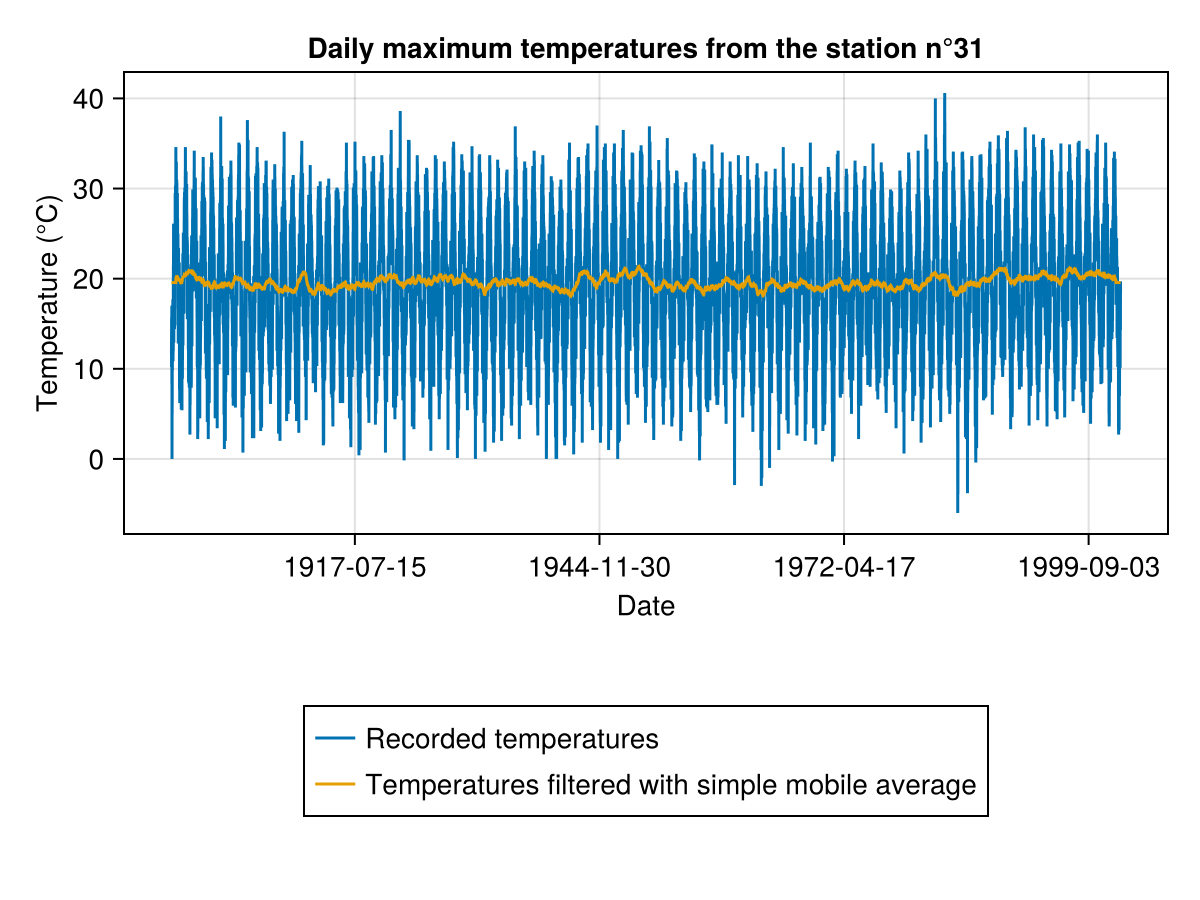

In [2]:
series,fig=extract_series("TX_STAID000031.txt",plot=true)
fig

## Drift

MSE estimators to estimate drift

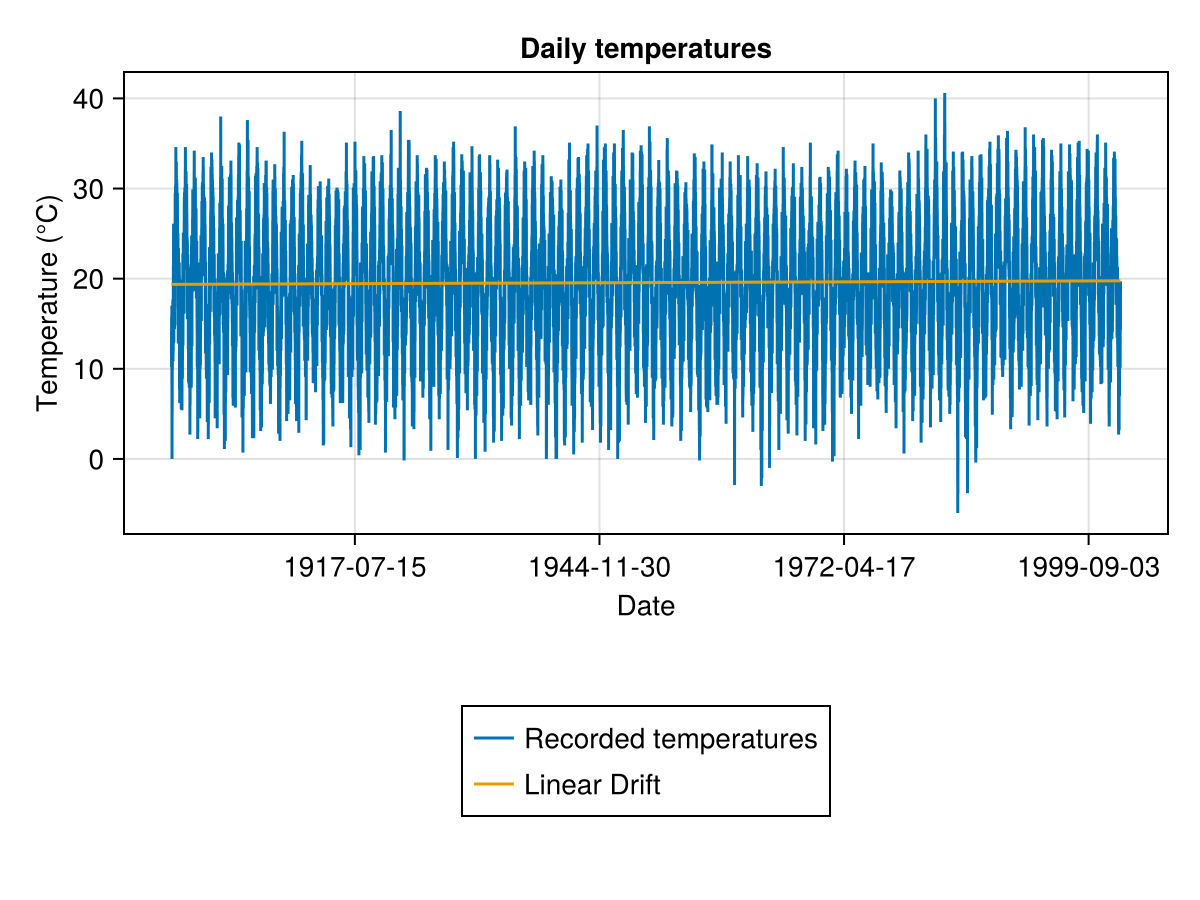

Intercept = 19.366009056392556
Slope = 1.0215034069842917e-5


In [3]:
N=size(series)[1]
X=cat(ones(N),1:N,dims=2)
beta=inv(transpose(X)*X)*transpose(X)*series[!,2]

fig=Figure()
ax, plot1=lines(fig[1:2, 1:2], series.DATE, series[!,2])
plot2=lines!(ax,series.DATE,X*beta)
ax.title="Daily temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3, 1:2],[plot1,plot2],["Recorded temperatures","Linear Drift"])
display(fig)

println("Intercept = $(beta[1])")
println("Slope = $(beta[2])")

We can see that the drift is (almost) only a constant. We can consider it in our periodicity component estimation, as the $\mu$ parameter.

In [4]:
try 
    using RCall
catch ; 
    import Pkg
    Pkg.add("RCall")
    using RCall
end
R"""
z<-$(series[!,2])
t<-1:$N
model<-lm(z~t)
summary(model)
"""

RObject{VecSxp}

Call:
lm(formula = z ~ t)

Residuals:
     Min       1Q   Median       3Q      Max 
-25.6939  -5.3835  -0.3396   5.6837  20.9115 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.937e+01  6.916e-02 280.020  < 2e-16 ***
t           1.021e-05  3.091e-06   3.305  0.00095 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.808 on 38756 degrees of freedom
Multiple R-squared:  0.0002818,	Adjusted R-squared:  0.000256 
F-statistic: 10.92 on 1 and 38756 DF,  p-value: 0.0009499



# 1.Trigonometrical parametrical model

In this model the periodicity $S_t$ will follow this equation :  $S_t = \mu + a\cos(\frac{2πt}{365.25}) + b\sin(\frac{2πt}{365.25})$. $\mu$, $a$ and $b$ will be estimated by fitting this equation on our series with an OLS regression.

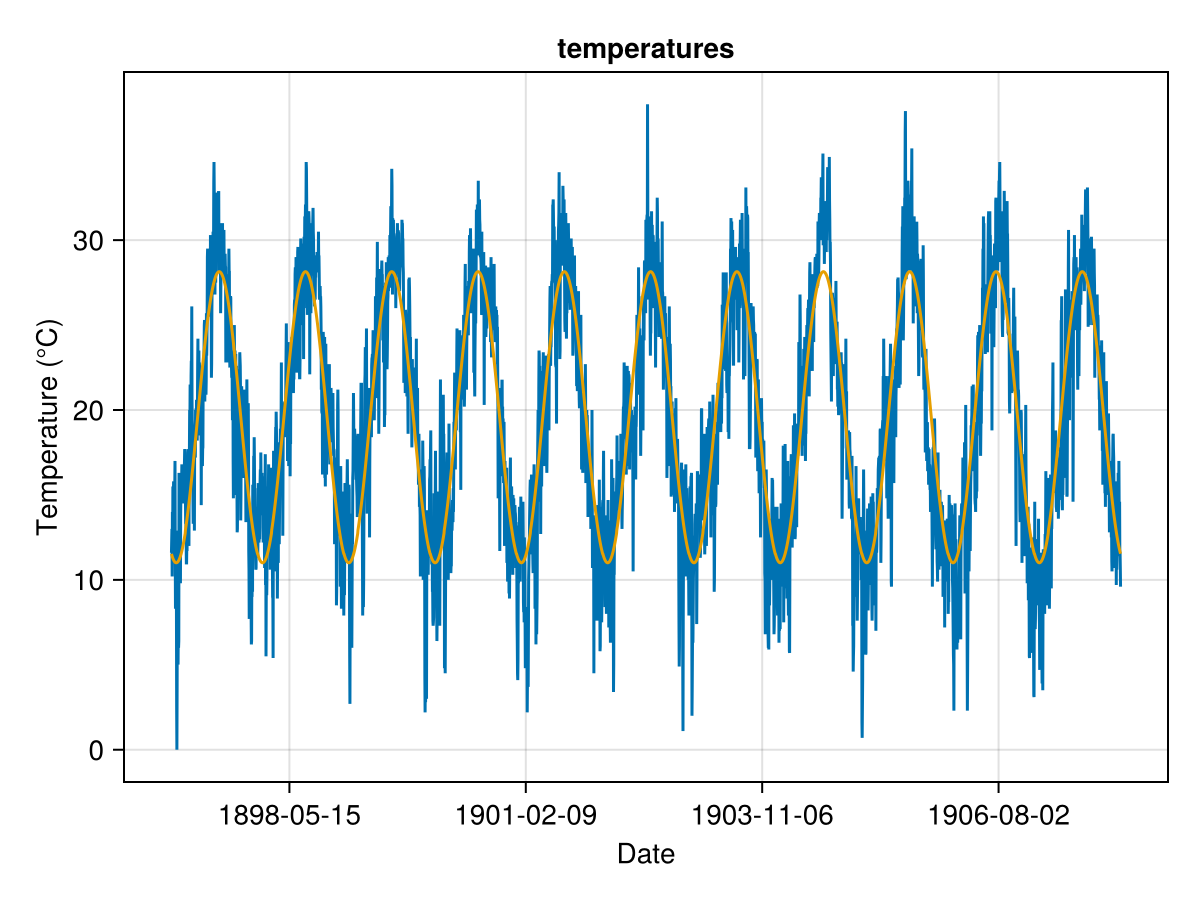

In [5]:
include("utils/Periodicity.jl")
trigo_function=fitted_periodicity_fonc(series[!,2],series.DATE)
periodicity=trigo_function.(series.DATE)

Myyear=Iyear(series.DATE,year(series.DATE[1]):year(series.DATE[1]) + 10)
fig, ax = lines(series.DATE[Myyear],series[Myyear,2])
lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

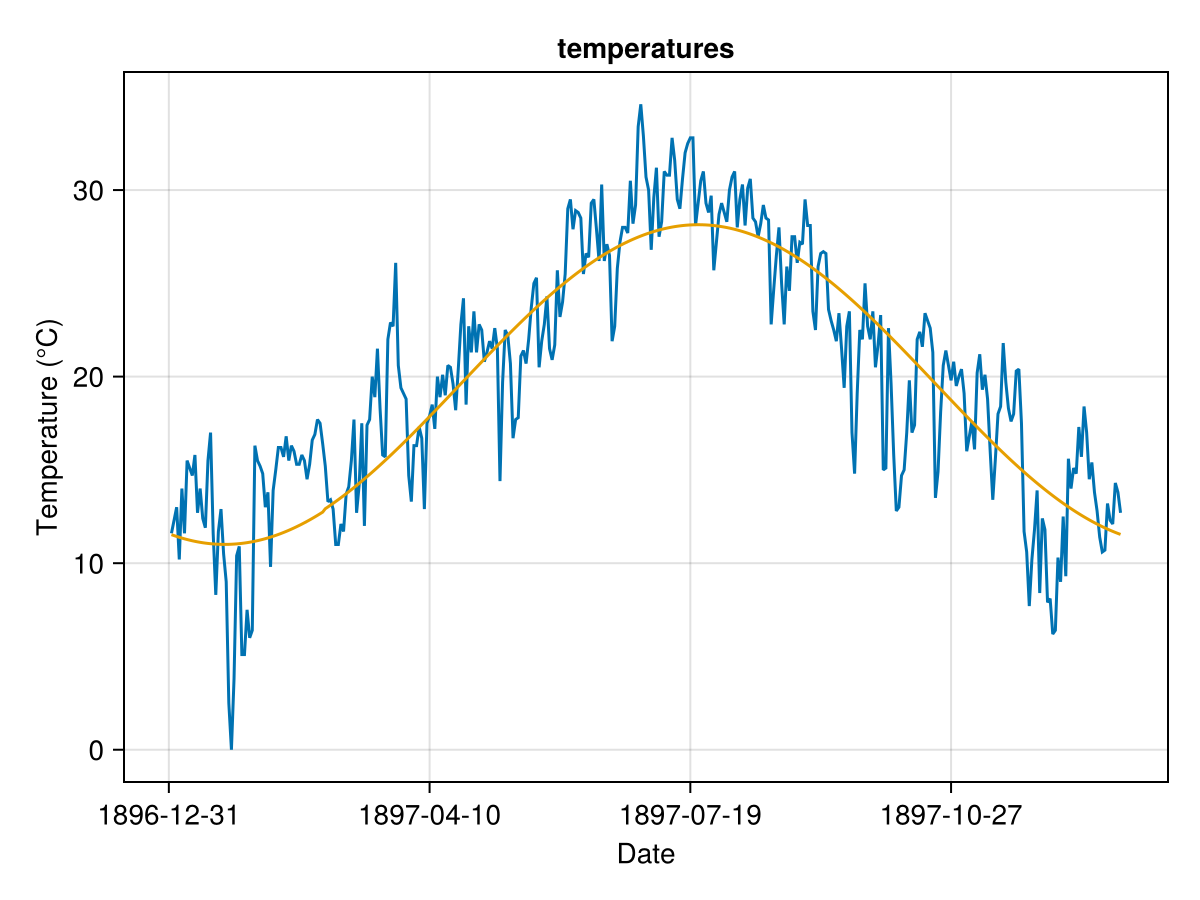

In [6]:
Myyear=Iyear(series.DATE,year(series.DATE[1]))
fig, ax = lines(series.DATE[Myyear],series[Myyear,2])
lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

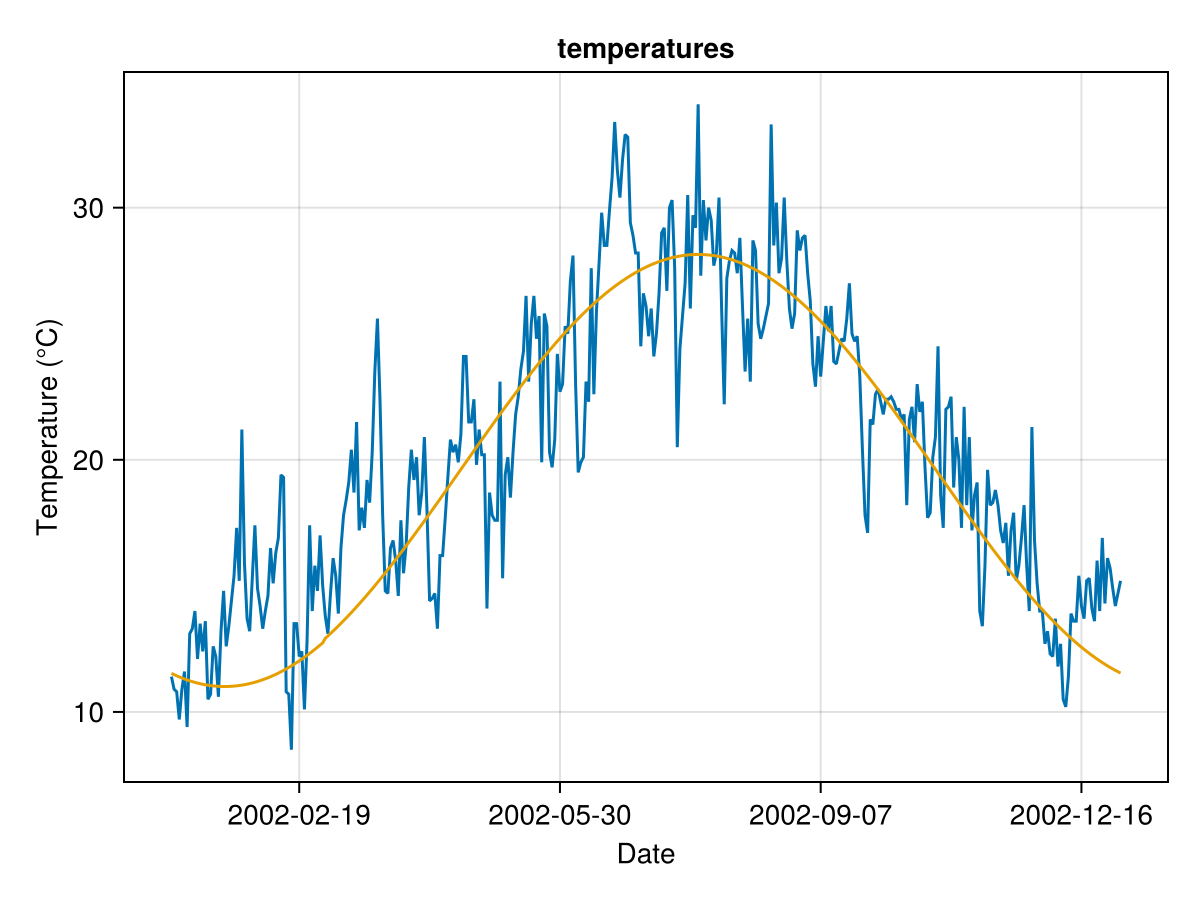

In [7]:
Myyear=Iyear(series.DATE,year(series.DATE[end])-1)
fig, ax = lines(series.DATE[Myyear],series[Myyear,2])
lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

Using the new fitted_periodicity_fonc function has corrected the periodicity shift issue for trigonometric estimation.

We will work on the series without the periodicity : 

In [8]:
x=series[!,2]-periodicity

38758-element Vector{Float64}:
  0.07104304037398812
  0.8205179297211718
  1.5675970551600766
 -1.1877335153749673
  2.654512999148631
  0.29432409677359495
  4.231687996252475
  3.866593640534054
  3.499030700035446
  4.628989575698913
  ⋮
  3.115653785732892
  0.9864740732926229
 -0.5439076135917666
 -1.475452691233622
  0.39187776833445476
  3.1581230258407125
  3.52332266315587
  1.9875165715796825
  2.5507449400359867

## Autocorrelations

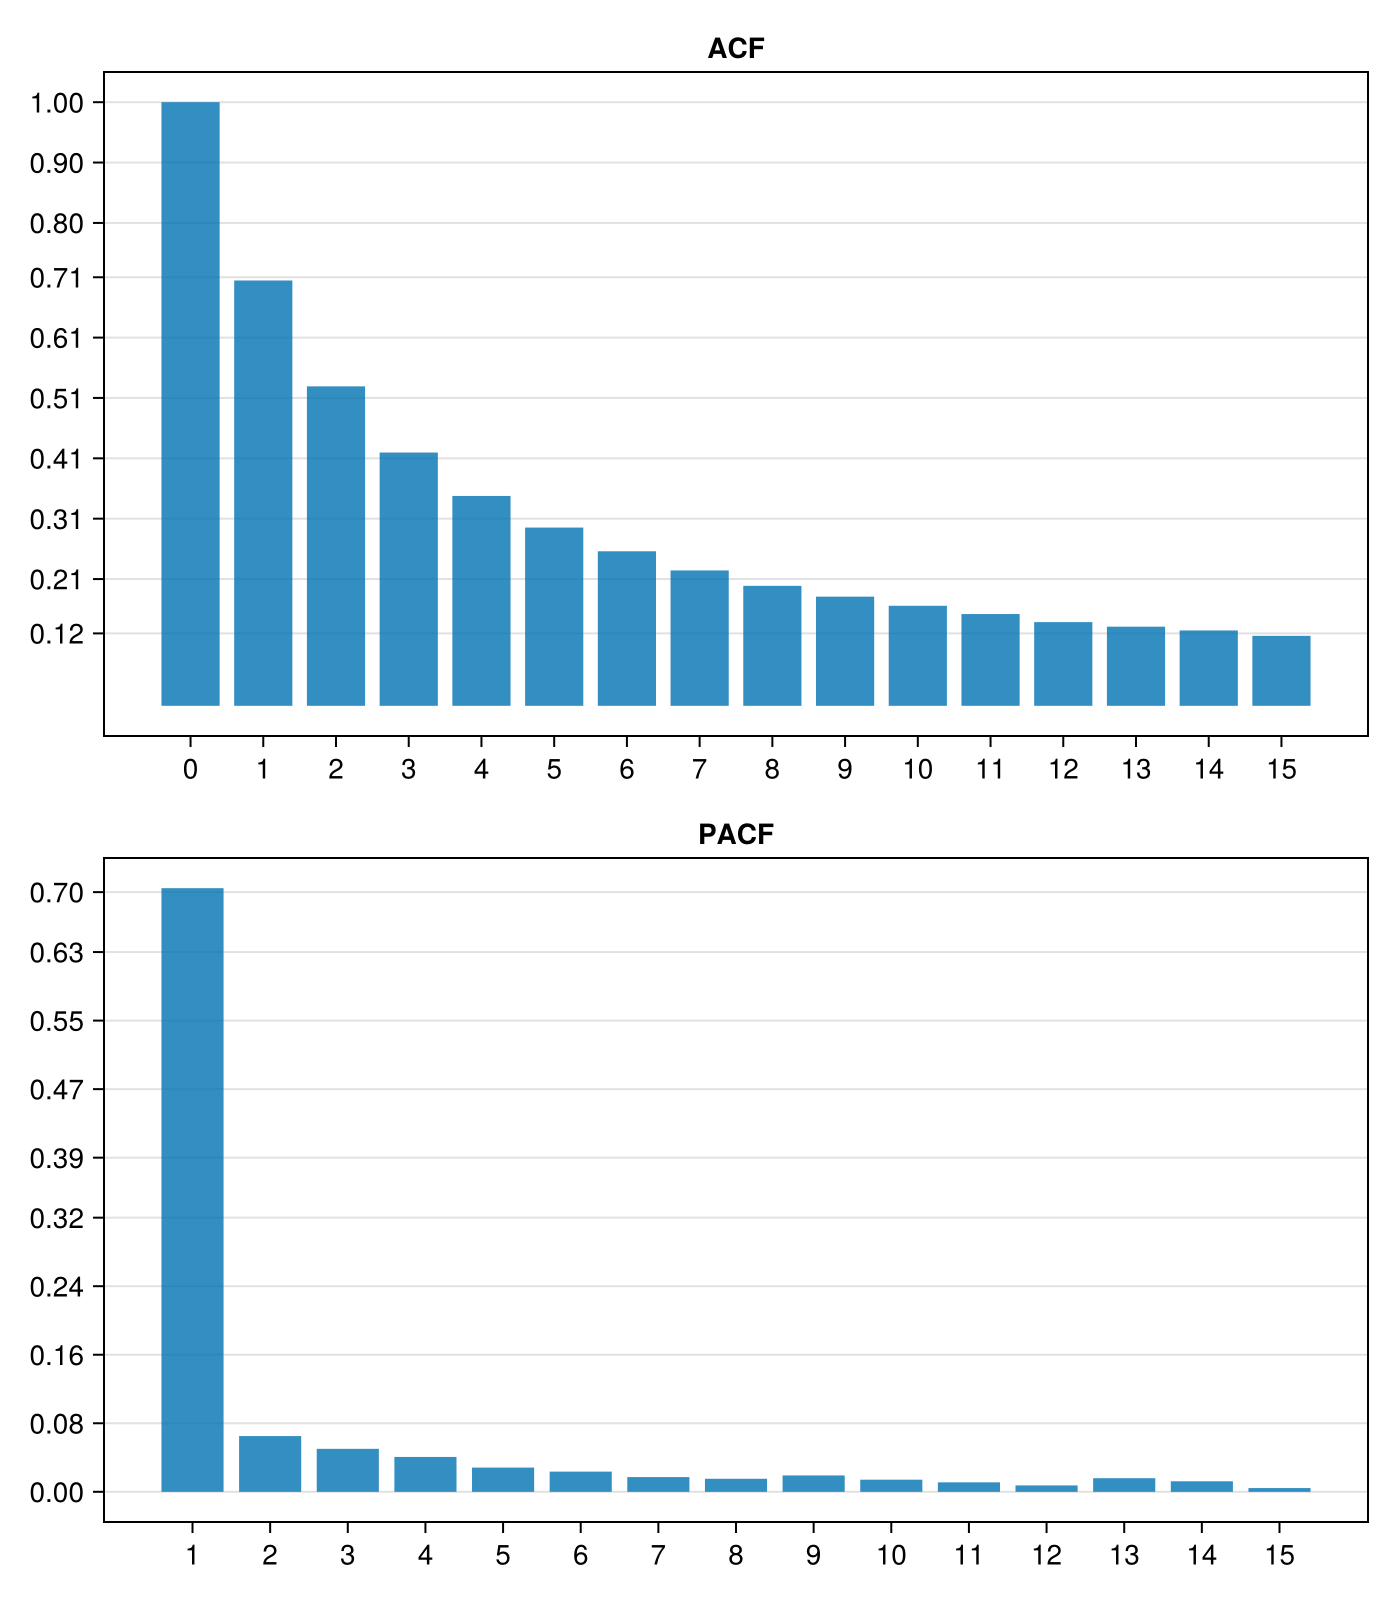

In [9]:
include("utils/ACF_PACF.jl")
ACF_PACF(x)

It still looks like an AR(1) model

## Estimation with Likelihood

In [24]:
include("utils/Estimation.jl")
p=1
Φ, σ=LL_AR_Estimation(x,p)

([0.6925118415674875], 2.1921763172557913)

## Sampling simulations

In [11]:
include("utils/Simulation.jl")
sample_=invert(sample_simulation(x[1:p],Φ,σ,periodicity,10000))

365-element Vector{Vector{Float64}}:
 [11.6, 13.513870229693536, 9.08771792096417, 11.363403322146542, 11.773610515158532, 14.464558455385426, 13.716741190653543, 15.617067670325152, 8.772701577099191, 9.578467635235508  …  14.214011889366189, 11.690644521047547, 10.880998218933563, 11.215387433626733, 12.7513111715818, 11.404923800970021, 13.81335375232486, 7.589940073503599, 10.562162535039606, 11.5378775655568]
 [10.036067505144347, 17.690856528810556, 10.817683342486411, 13.308105270177457, 14.931282212154228, 10.886480380950191, 12.679514887155998, 15.403196780870308, 11.95259717106511, 9.213308649315762  …  9.943243444893755, 11.047432513781905, 10.569654396151849, 11.726183824545954, 12.384792514198779, 11.891311773194476, 18.813478211989572, 8.019434115617315, 10.890214728922366, 13.015572277398826]
 [11.495403263699826, 17.87097926791967, 10.856176453134523, 13.39200800495277, 13.864535323964247, 13.891677886117185, 10.478373609682674, 14.678791390085097, 13.422152585270442, 8

To apply statistical functions on each days, the sample vector will be inverted (if it was shaped like v[year][day], no it is shaped like v[day][year]).

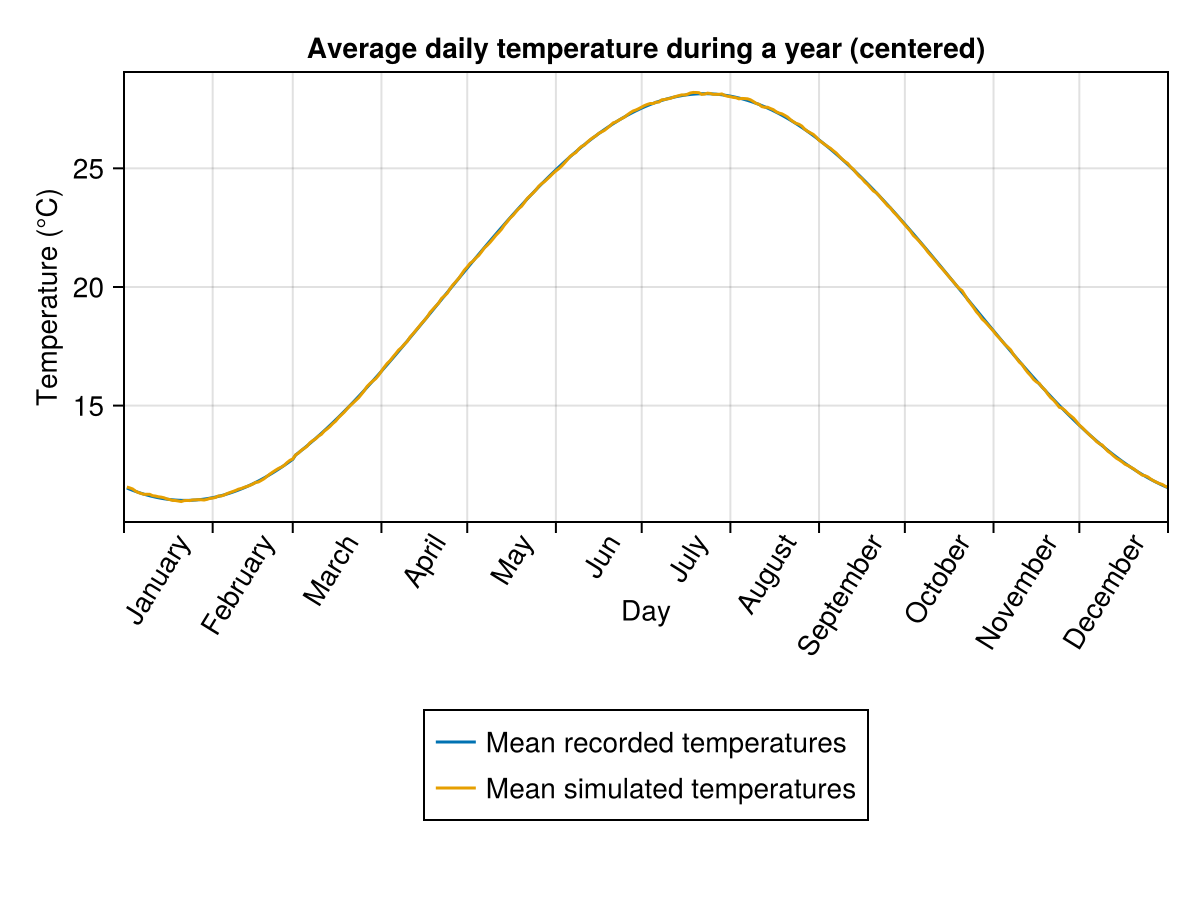

In [12]:
include("utils/Plotting.jl")
PlotYearCurves([periodicity[1:365],mean.(sample_)],["Mean recorded temperatures","Mean simulated temperatures"],"Average daily temperature during a year (centered)")

The generated sample seems to be unbiased.

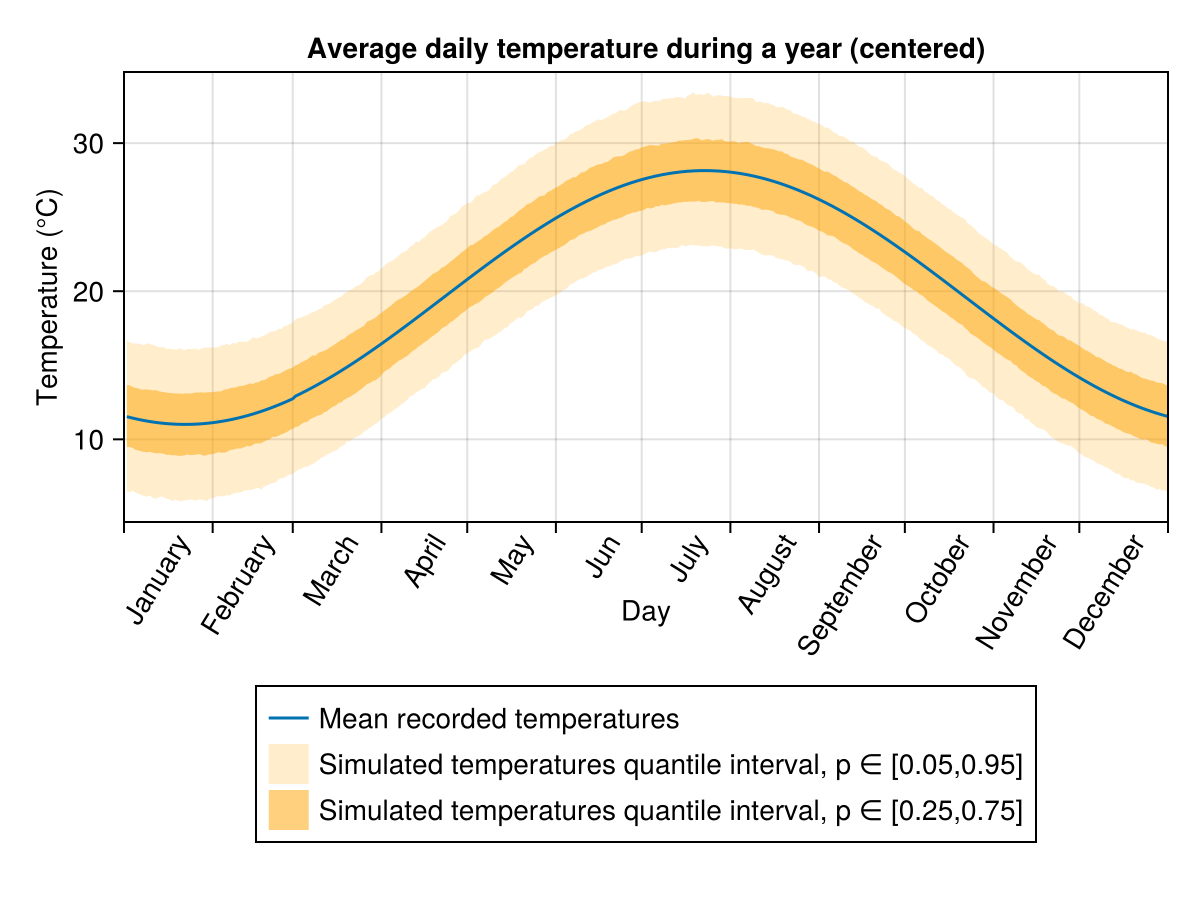

In [13]:
PlotYearCurves(periodicity[1:365],
["Mean recorded temperatures","Simulated temperatures quantile interval, p ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
)

# 2.Periodicity with regularization smoothing

In this model we use regularization smoothing on the average daily temperature to make our periodicity function. 
(see : https://docs.sciml.ai/DataInterpolations/stable/methods/)

In [14]:
Days_list=[[] for _ in 1:366]
for (i,temp) in enumerate(series[!,2])
    push!(Days_list[dayofyear_Leap(series.DATE[i])],temp) #The right day of the year is now associated with the temperature (before we just counted the number of day as i without considering missing days)
end
Days_list

366-element Vector{Vector{Any}}:
 [11.6, 11.3, 9.8, 15.8, 11.1, 14.7, 8.5, 12.9, 1.6, 8.0  …  10.4, 11.0, 16.3, 9.4, 15.3, 13.2, 12.2, 14.2, 11.4, 13.8]
 [12.3, 12.4, 15.2, 17.8, 10.7, 9.8, 11.0, 14.3, 0.7, 9.0  …  12.8, 5.3, 13.6, 12.9, 13.9, 13.1, 12.7, 15.2, 10.9, 17.8]
 [13.0, 15.7, 9.1, 18.8, 7.6, 16.0, 14.7, 14.0, 8.7, 9.5  …  16.0, 7.8, 13.6, 12.7, 15.0, 14.0, 13.3, 14.0, 10.8, 15.3]
 [10.2, 14.1, 11.8, 13.8, 6.3, 17.6, 14.6, 10.8, 4.1, 13.4  …  11.8, 5.9, 15.2, 7.4, 14.3, 18.0, 14.2, 13.5, 9.7, 13.8]
 [14.0, 13.9, 15.7, 12.1, 4.5, 14.3, 15.5, 12.0, 9.7, 15.0  …  13.3, 7.7, 11.8, 8.0, 14.9, 17.2, 12.9, 16.0, 10.9, 7.4]
 [11.6, 12.2, 15.4, 12.8, 4.1, 12.3, 15.0, 12.7, 9.7, 14.0  …  13.2, 3.6, 11.7, 10.8, 15.1, 14.7, 13.7, 17.2, 11.6, 7.8]
 [15.5, 12.4, 14.1, 11.0, 5.3, 13.2, 14.7, 12.5, 14.0, 11.2  …  12.4, 7.8, 14.1, 11.5, 15.4, 15.2, 13.2, 10.8, 9.4, 3.4]
 [15.1, 12.8, 14.3, 11.0, 9.9, 13.5, 15.3, 14.3, 16.5, 14.5  …  11.4, 8.0, 16.9, 10.0, 16.1, 15.3, 15.0, 11.5, 13.1, 6.4]
 [

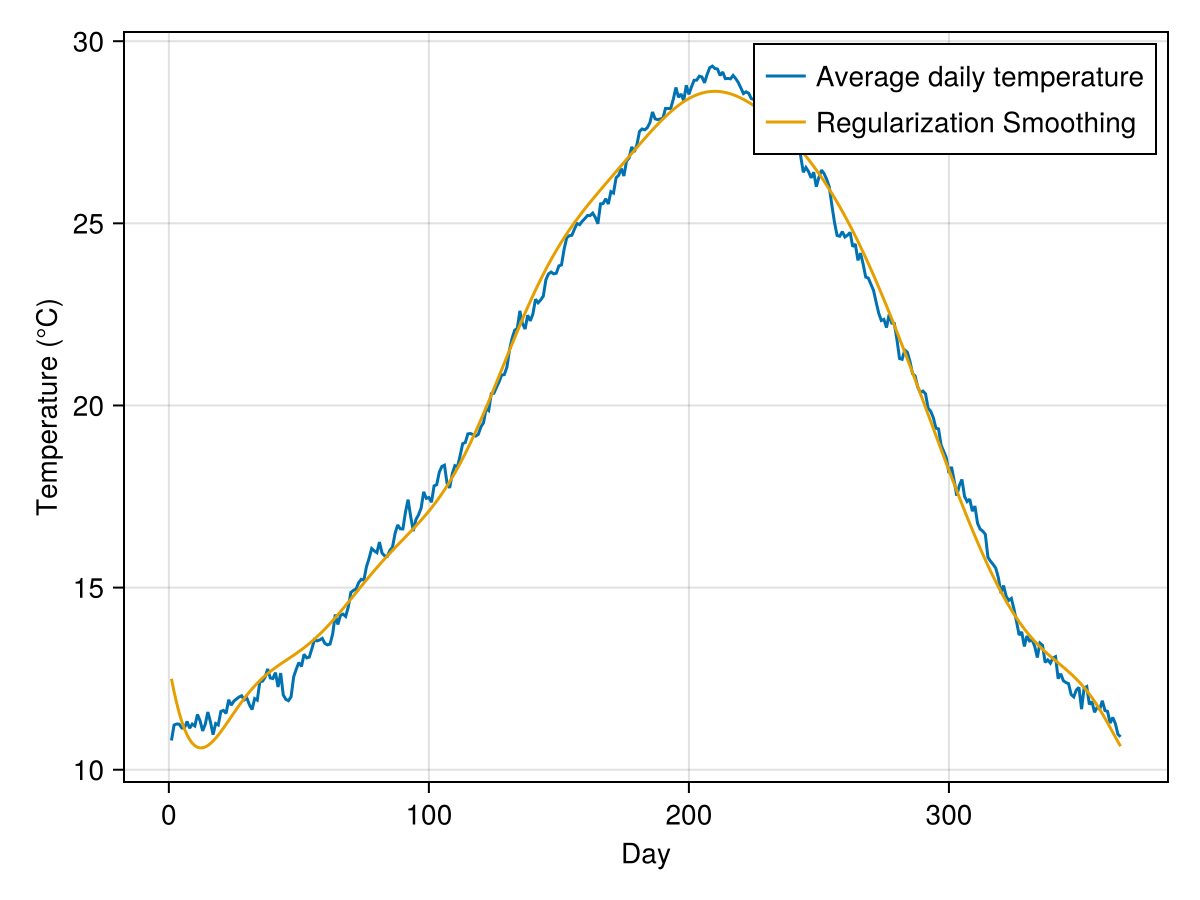

In [15]:
f=RegularizationSmooth(mean.(Days_list), 1:366, 9)
fig=Figure()
ax ,plt1= lines(fig[1:2,1:2],mean.(Days_list))
plt2=lines!(ax,f(1:366))
ax.xlabel="Day"
ax.ylabel="Temperature (°C)"
axislegend(ax,[plt1,plt2],["Average daily temperature","Regularization Smoothing"])
current_figure()

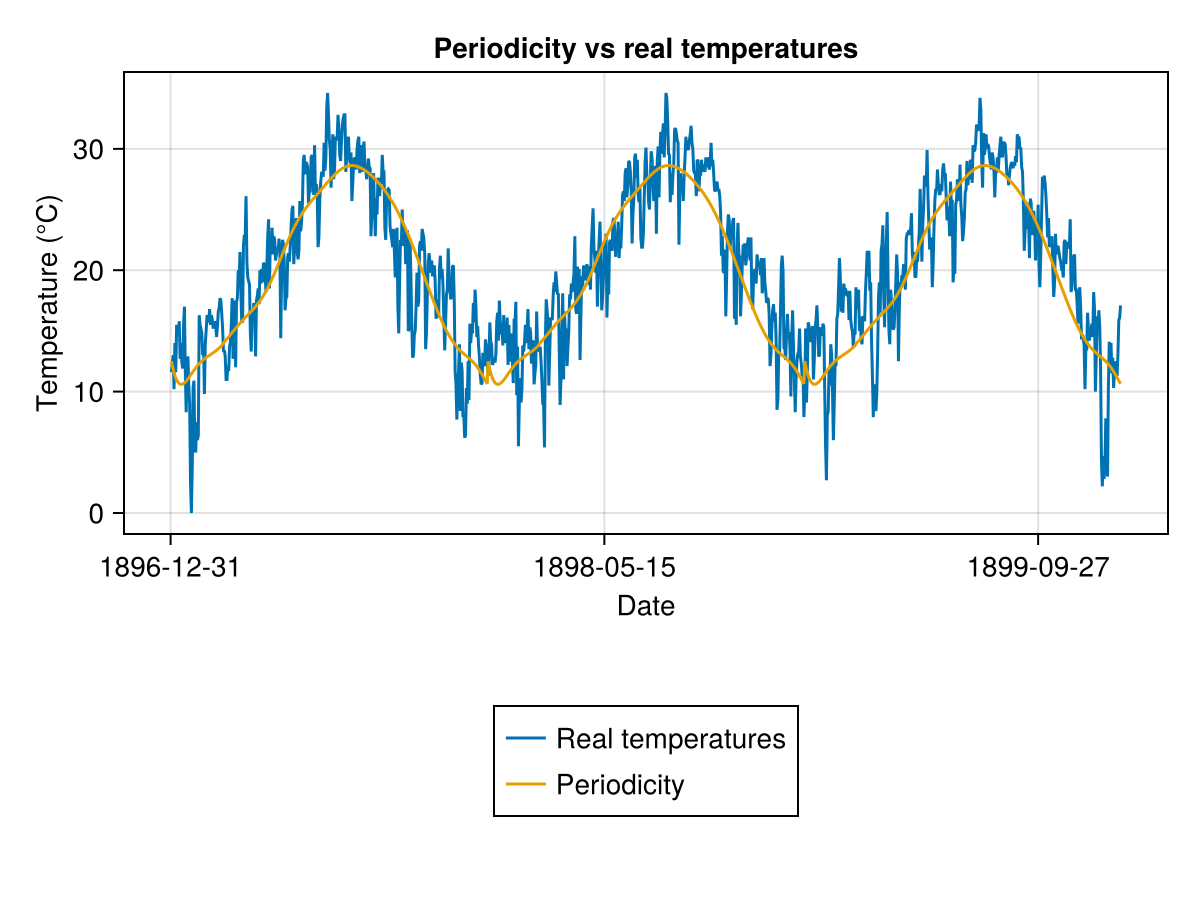

In [16]:
periodicity=f.(dayofyear_Leap.(series.DATE)) #f depends on the real date

fig=Figure()
Myyear=Iyear(series.DATE,year(series.DATE[1]):year(series.DATE[1]) + 2)
ax ,plt1= lines(fig[1:2,1:2],series.DATE[Myyear],series[Myyear,2])
plt2=lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="Periodicity vs real temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3,1:2],[plt1,plt2],["Real temperatures","Periodicity"])
current_figure()

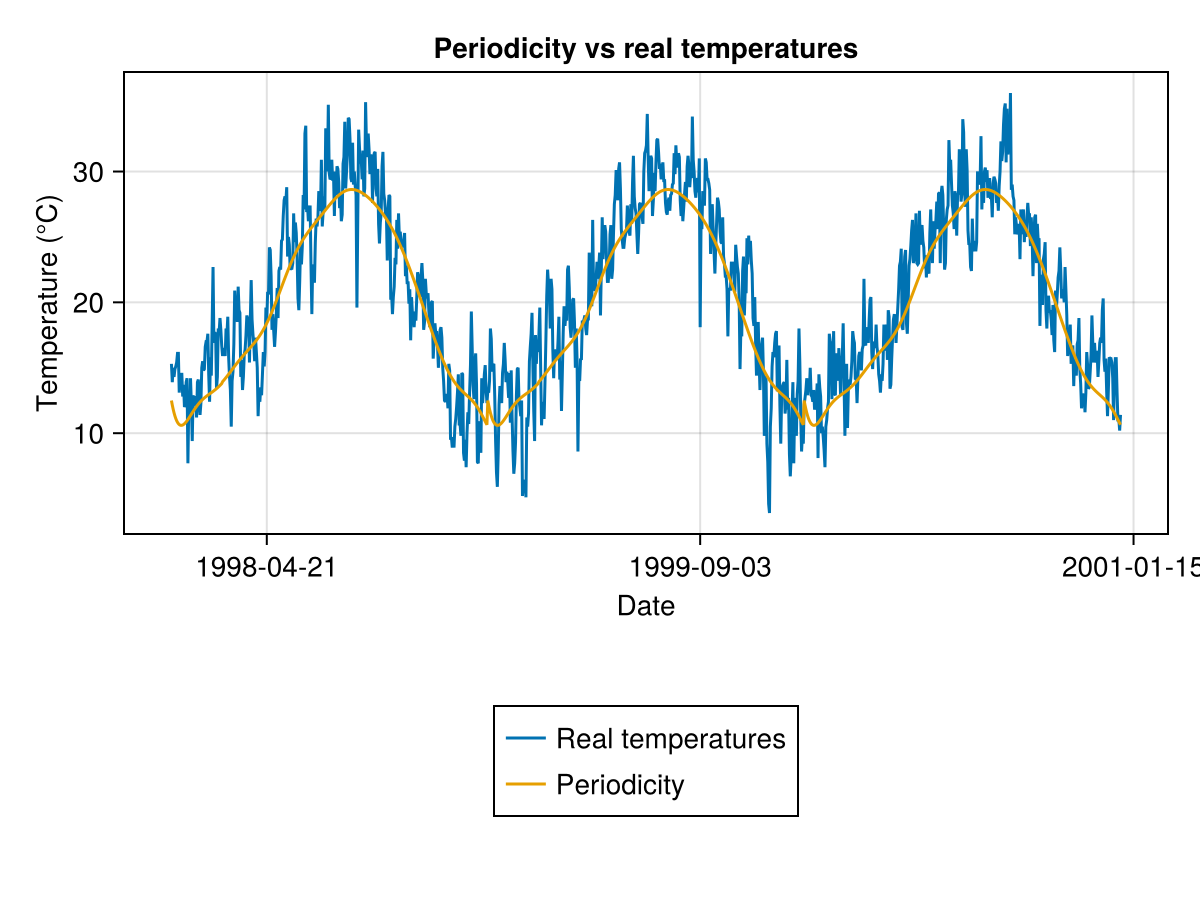

In [17]:
fig=Figure()
Myyear=Iyear(series.DATE,year(series.DATE[37000]):year(series.DATE[37000]) + 2)
ax ,plt1= lines(fig[1:2,1:2],series.DATE[Myyear],series[Myyear,2])
plt2=lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="Periodicity vs real temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3,1:2],[plt1,plt2],["Real temperatures","Periodicity"])
current_figure()

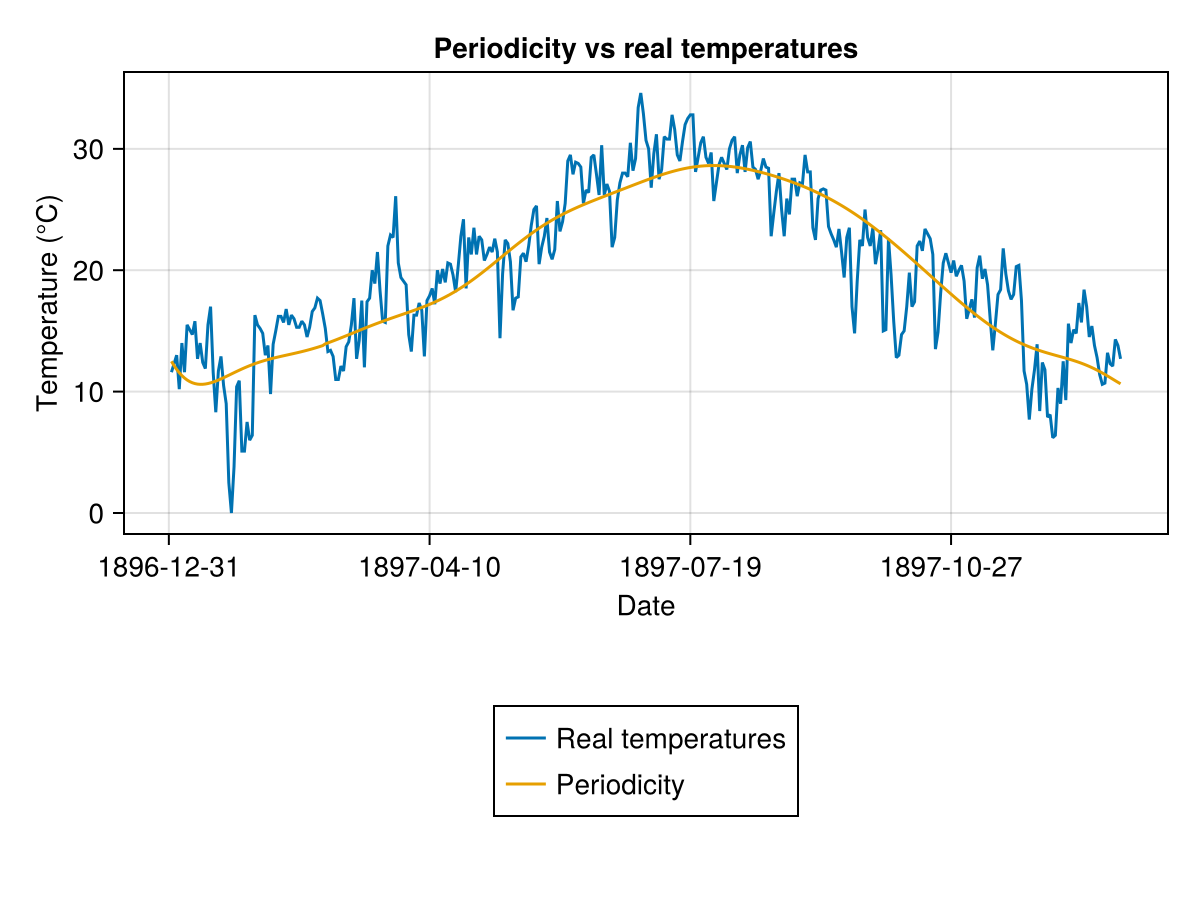

1897-01-01
1897-12-31


CairoMakie.Screen{IMAGE}


In [18]:
fig=Figure()
Myyear=Iyear(series.DATE,year(series.DATE[1]))
ax ,plt1= lines(fig[1:2,1:2],series.DATE[Myyear],series[Myyear,2])
plt2=lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="Periodicity vs real temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3,1:2],[plt1,plt2],["Real temperatures","Periodicity"])
println(series.DATE[Myyear][1])
println(series.DATE[Myyear][end])
display(fig)

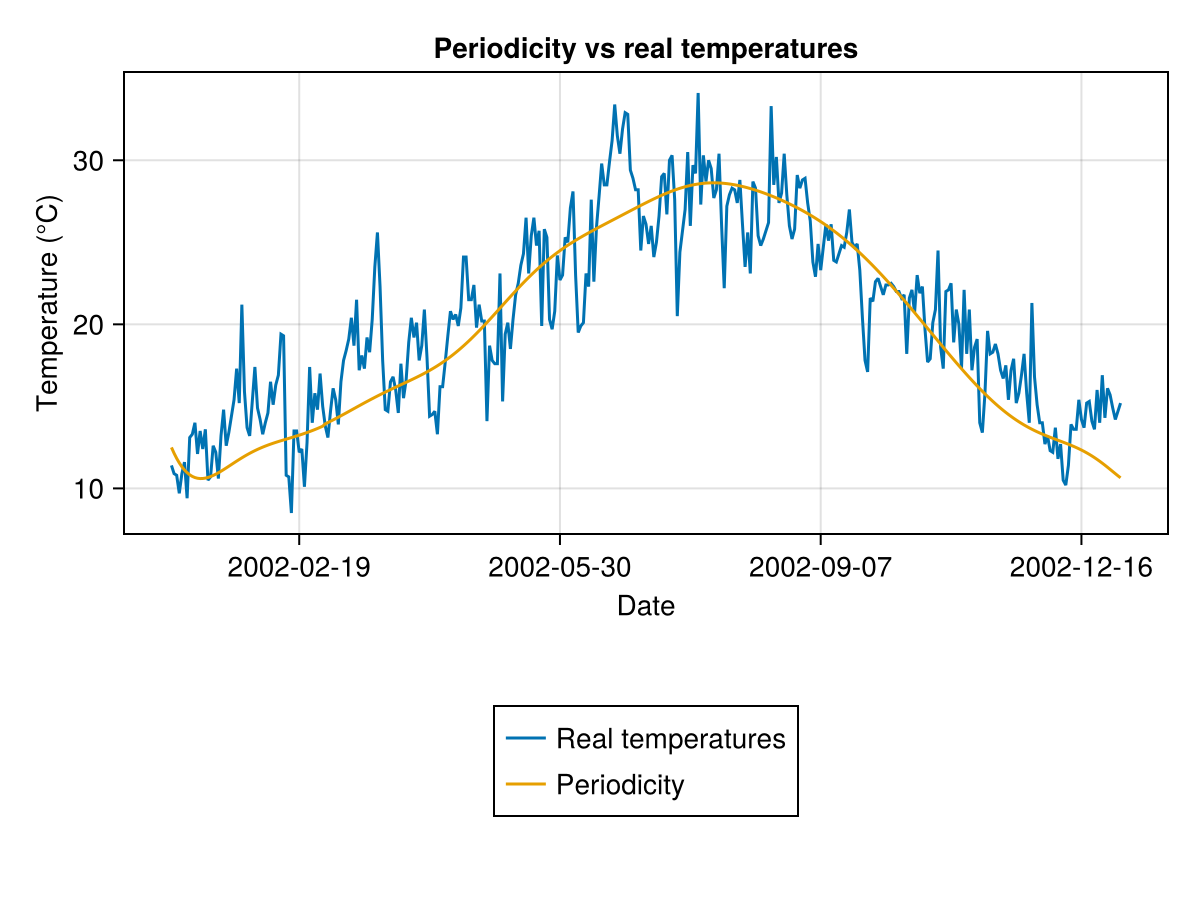

2002-01-01
2002-12-31


CairoMakie.Screen{IMAGE}


In [19]:
fig=Figure()
Myyear=Iyear(series.DATE,year(series.DATE[end])-1)
ax ,plt1= lines(fig[1:2,1:2],series.DATE[Myyear],series[Myyear,2])
plt2=lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="Periodicity vs real temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3,1:2],[plt1,plt2],["Real temperatures","Periodicity"])
println(series.DATE[Myyear][1])
println(series.DATE[Myyear][end])
display(fig)

By making the regularization function depending of the real date and not on the index of the series we also corrected the shift. 

## Estimation with Likelihood

In [20]:
include("utils/Estimation.jl")
x=series[!,2]-periodicity
p=1
Φ, σ=LL_AR_Estimation(x,p)

([0.6925118415674875], 2.1921763172557913)

## Sampling simulations

In [21]:
include("utils/Simulation.jl")
sample_=invert(sample_simulation(x[1:p],Φ,σ,periodicity,10000))

365-element Vector{Vector{Float64}}:
 [11.6, 11.082762384986337, 15.031886179696782, 15.16952708654001, 17.543787120727224, 14.957483625396062, 13.374490311891424, 14.977347864152033, 14.598053510116943, 13.305322535031618  …  10.458053668171225, 11.680906317552557, 6.128551020663792, 12.219822157843211, 10.490864773081316, 14.526467829240948, 14.894850901175632, 13.110378871718451, 15.378179449155155, 11.881322644076795]
 [9.16672092636156, 10.296185160505186, 16.18835254820915, 15.498529948167178, 20.30193965465045, 11.466943497594395, 7.717630715137814, 10.844891177357963, 15.857612823621508, 12.33050414671327  …  10.329529682141171, 12.763112191237836, 10.253676463898252, 11.489334089692722, 13.65102302097479, 13.223288645619782, 14.538048634448465, 14.82314721799073, 11.264142960105776, 11.095806069041085]
 [12.435357038596065, 6.906006513646891, 14.872351480752988, 17.483771614345446, 17.45322724023695, 10.88805541449545, 7.136321532431686, 13.15617347916114, 18.79367531624635, 1

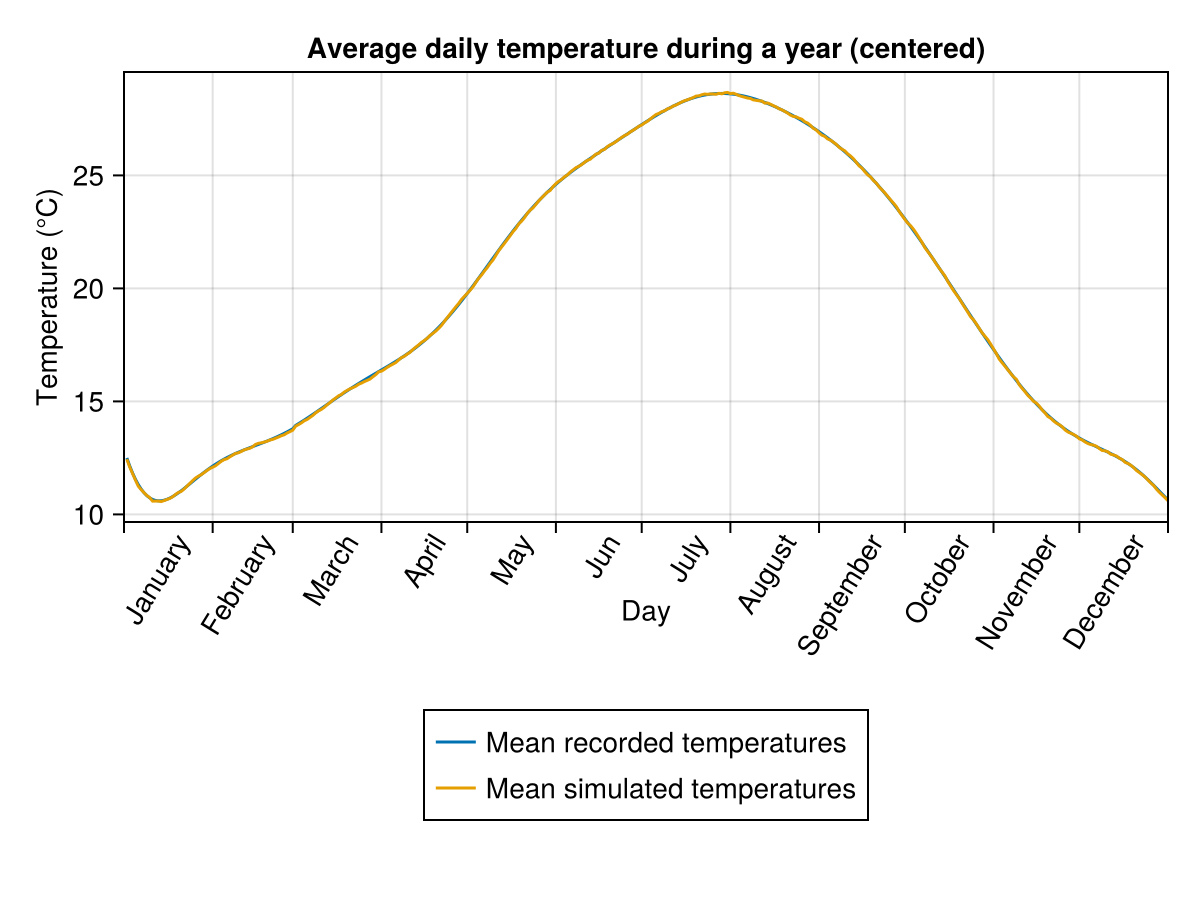

In [22]:
include("utils/Plotting.jl")
PlotYearCurves([periodicity[1:365],mean.(sample_)],["Mean recorded temperatures","Mean simulated temperatures"],"Average daily temperature during a year (centered)")

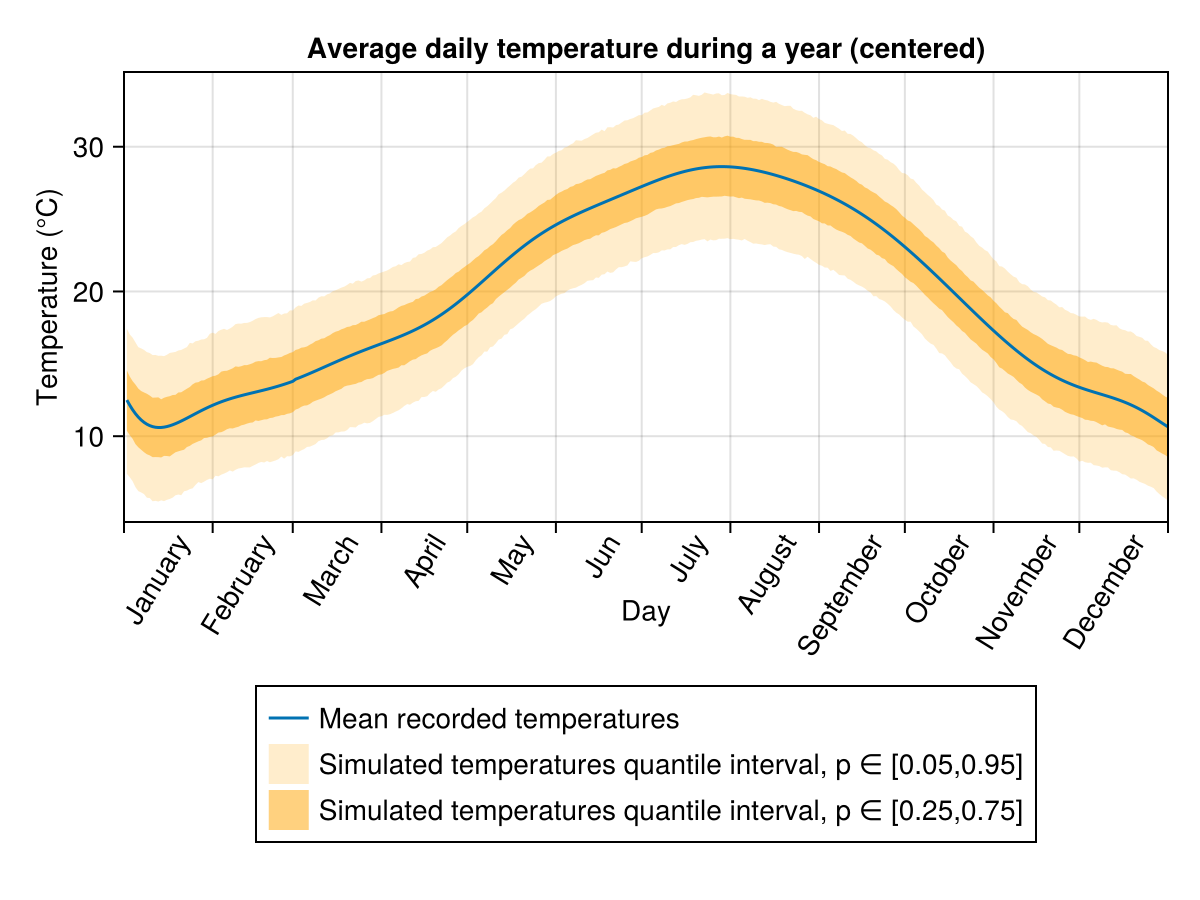

In [23]:
PlotYearCurves(periodicity[1:365],
["Mean recorded temperatures","Simulated temperatures quantile interval, p ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
)